# Zero-Shot Object Detection with Gemma 3
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/lab176344/vlm-notebookss/blob/main/notebooks/inference/exploration-gemma3.ipynb)

Google's Gemma 3  is an open weights research release which comes in 1b, 4b, 12b and 27b parameters with advanced capabilities optimized for a variety of vision-language use cases, including OCR, captioning, visual reasoning, summarization, question answering, code, and more. It is a multilingual model trained to excel in 23 languages in vision and language.

## Environment setup

### Configure your API keys

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.


In [3]:
import os
from google.colab import userdata

os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")

### Check GPU availability

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [4]:
!nvidia-smi

Fri Mar  7 11:04:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.15              Driver Version: 570.86.15      CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             44W /  400W |       1MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

### Install dependencies

Installs all required python libraries, including [`maestro`](https://github.com/roboflow/maestro) for Qwen2.5-VL and [`supervision`](https://github.com/roboflow/supervision) for visualization.

In [ ]:
! pip install git+https://github.com/huggingface/transformers@v4.49.0-Gemma-3

! pip install supervision opencv-python matplotlib requests numpy


  Cloning https://github.com/huggingface/transformers.git (to revision v4.49.0-AyaVision) to /tmp/pip-req-build-urk77s71
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-urk77s71
  Running command git checkout -q 512e07332568b69b219f260bf0864d8ae6156750
  Resolved https://github.com/huggingface/transformers.git to commit 512e07332568b69b219f260bf0864d8ae6156750
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 3.8 MB/s eta 0:00:00


## Load Gemma 3 model, and do necessary imports


In [ ]:
from transformers import AutoProcessor, Gemma3ForCausalLM
import torch
import requests
import cv2
import numpy as np
import json
import supervision as sv
from matplotlib import pyplot as plt
import re

model_id = "google/gemma-3-1b-pt"

processor = AutoProcessor.from_pretrained(model_id)
model = Gemma3ForCausalLM.from_pretrained(
    model_id, device_map="auto", torch_dtype=torch.float16
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

# Zero Shot Object Detection
Loads the Aya-8B model model (and its processor) from Hugging Face, preparing the model for inference.

Here are the bounding box coordinates for each person in the image, formatted as JSON:

```json
{
  "person1": {
    "x1": 127.58,
    "y1": 104.44,
    "x2": 293.09,
    "y2": 298.44
  },
  "person2": {
    "x1": 294.09,
    "y1": 104.44,
    "x2": 458.58,
    "y2": 298.44
  },
  "person3": {
    "x1": 459.58,
    "y1": 104.44,
    "x2": 624.09,
    "y2": 298.44
  },
  "person4": {
    "x1": 625.58,
    "y1": 104.44,
    "x2": 789.09,
    "y2": 298.44
  }
}
```

These coordinates represent the top-left and bottom-right corners of each person's bounding box in the image.


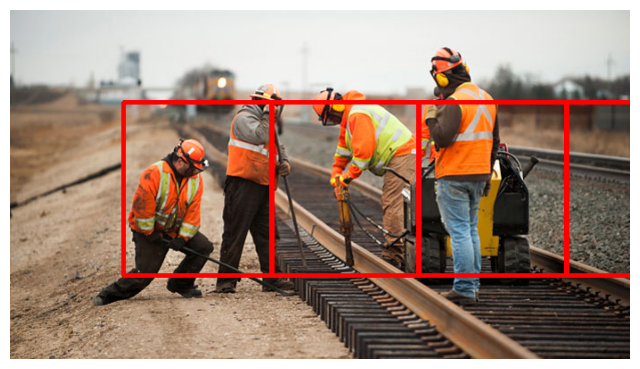

In [34]:
image_url = "https://www.minneapolisfed.org/-/media/images/pubs/fedgaz/15-04/key-images/working-on-the-railroad-key.jpg"
response = requests.get(image_url, stream=True)
image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
resolution_wh = (364,364) # Aya Input resolution



messages = [
    {"role": "user",
     "content": [
       {"type": "image", "url": image_url},
        {"type": "text", "text": "Find the persons in the image. Return the bounding box coordinates, x1, y2, x2, y2 in json with keys as the label and values x1, x2, y1, y2"},
    ]},
    ]

inputs = processor.apply_chat_template(
    messages, padding=True, add_generation_prompt=True, tokenize=True, return_dict=True, return_tensors="pt"
).to(model.device)

gen_tokens = model.generate(
    **inputs,
    max_new_tokens=300,
    do_sample=True,
    temperature=0.3,
)

text_response = processor.tokenizer.decode(gen_tokens[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)
print(text_response)



# Visualise the output
json_match = re.search(r'\{[\s\S]*\}', text_response)
if json_match:
    json_data = json_match.group(0)
    bbox_data = json.loads(json_data)
else:
    raise ValueError("JSON data not found in response.")
# Todo: Scaling of bbox coordinated
bboxes = []
class_ids = []
class_id = 0 # Person
for idx, (key, value) in enumerate(bbox_data.items()):
    x1, y1, x2, y2 = value["x1"], value["y1"], value["x2"], value["y2"]
    bboxes.append([x1, y1, x2, y2])
    class_ids.append(class_id)

bboxes = np.array(bboxes)
class_ids = np.array(class_ids)

bounding_box_annotator = sv.BoxAnnotator(color=sv.Color.RED, thickness=3)
bbox_xyxy = sv.Detections(xyxy=bboxes, class_id=class_ids)
annotated_image = bounding_box_annotator.annotate(scene=image, detections=bbox_xyxy)
annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8, 6))
plt.imshow(annotated_image)
plt.axis("off")
plt.show()



# Counting

Analayse the model on counting task


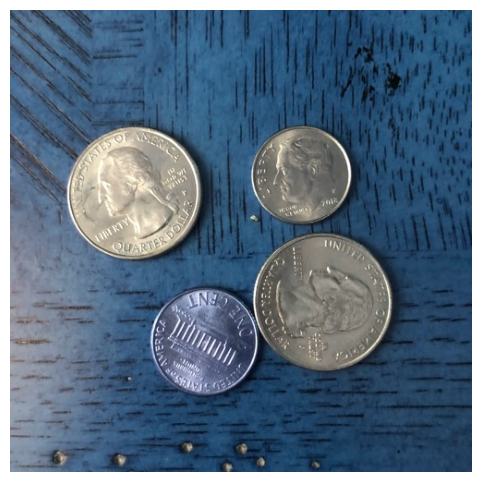

There are six coins in the image. Specifically, there are:

1. One nickel (5 cents)
2. One dime (10 cents)
3. One quarter (25 cents)
4. One penny (1 cent)
5. One quarter (25 cents)
6. One dime (10 cents)

These coins are arranged in a small pile on a wooden surface.


In [29]:
# Format message with the aya-vision chat template
counting_image_url = "https://i1.sndcdn.com/artworks-000631939663-rvxff5-t500x500.jpg"
messages = [
    {"role": "user",
     "content": [
       {"type": "image", "url": counting_image_url},
        {"type": "text", "text": "How many coins are there in the image?"},
    ]},
    ]

inputs = processor.apply_chat_template(
    messages, padding=True, add_generation_prompt=True, tokenize=True, return_dict=True, return_tensors="pt"
).to(model.device)

gen_tokens = model.generate(
    **inputs,
    max_new_tokens=300,
    do_sample=True,
    temperature=0.3,
)
response = requests.get(counting_image_url, stream=True)
image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis("off")
plt.show()
print(processor.tokenizer.decode(gen_tokens[0][inputs.input_ids.shape[1]:], skip_special_tokens=True))

# OCR

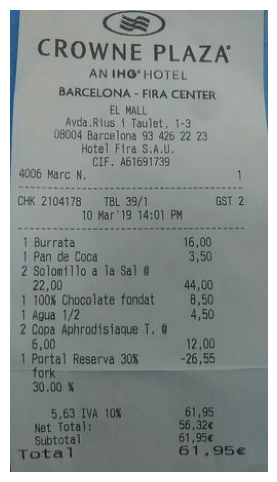

Here's the structured information extracted from the receipt:

**Hotel Information:**

* **Name:** Crowne Plaza Barcelona - Fira Center
* **Address:** Avda. Ruiz de Taull, 1-32, 08004 Barcelona, Spain
* **Contact:** +34 93 422 22 23

**Receipt Details:**

* **Date:** March 19, 2019
* **Time:** 14:01 PM
* **Invoice Number:** CHK2104178

**Items Purchased:**

| Item Name            | Quantity | Price (EUR) |
|-----------------------|----------|----------------|
| Burrita Coca         | 1        | 16.00         |
| Solomillo a la Sal   | 2        | 4.50          |
| Chocolate Fondant    | 2        | 4.50          |
| Agua                 | 2        | 4.50          |
| Aperol Spritz        | 2        | 12.00         |
| Porta                 | 1        | -2.55         |

**Summary:**

* **Subtotal:** 61.95 EUR
* **Tax:** 6.33 EUR (10%)


In [46]:
ocr_image_url = "https://media-cdn.tripadvisor.com/media/photo-s/16/c3/c0/e3/restaurant-receipt.jpg"

messages = [
    {"role": "user",
     "content": [
       {"type": "image", "url": ocr_image_url},
        {"type": "text", "text": "Extract the text from the image and return a structured output, extract the prices, item and quantity"},
    ]},
    ]

inputs = processor.apply_chat_template(
    messages, padding=True, add_generation_prompt=True, tokenize=True, return_dict=True, return_tensors="pt"
).to(model.device)

gen_tokens = model.generate(
    **inputs,
    max_new_tokens=300,
    do_sample=True,
    temperature=0.3,
)
response = requests.get(ocr_image_url, stream=True)
image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis("off")
plt.show()
print(processor.tokenizer.decode(gen_tokens[0][inputs.input_ids.shape[1]:], skip_special_tokens=True))

# VQA

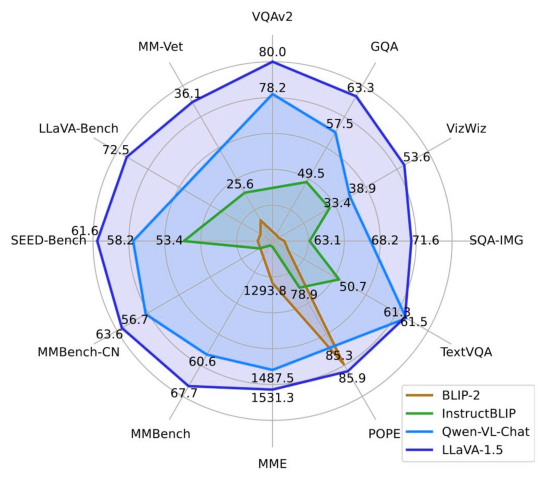

The model with the second best performance in the LLAVA-Bench benchmark is **Qwen-VL-Chat**. This model achieved a score of **57.5**, which is just slightly lower than the top-performing model, **LLaVA-1.5**, which scored **72.5**.


In [41]:
vqa_url = "https://raw.githubusercontent.com/haotian-liu/LLaVA/1a91fc274d7c35a9b50b3cb29c4247ae5837ce39/images/llava_v1_5_radar.jpg"
messages = [
    {"role": "user",
     "content": [
       {"type": "image", "url": vqa_url},
        {"type": "text", "text": "Which model has the second best performance in LLAVA-Bench"},
    ]},
    ]

inputs = processor.apply_chat_template(
    messages, padding=True, add_generation_prompt=True, tokenize=True, return_dict=True, return_tensors="pt"
).to(model.device)

gen_tokens = model.generate(
    **inputs,
    max_new_tokens=300,
    do_sample=True,
    temperature=0.3,
)
response = requests.get(vqa_url, stream=True)
image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis("off")
plt.show()
print(processor.tokenizer.decode(gen_tokens[0][inputs.input_ids.shape[1]:], skip_special_tokens=True))

# Image captions

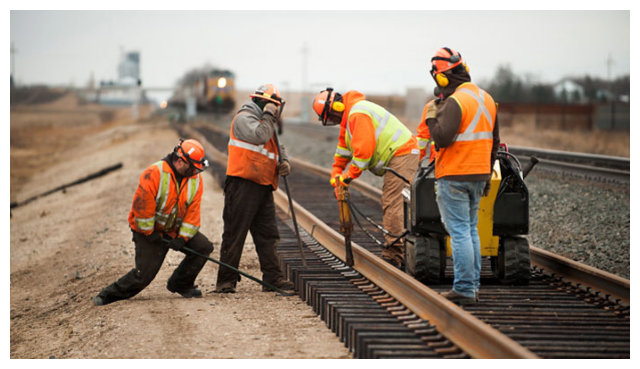

Four construction workers in high-visibility orange vests and hard hats are diligently repairing a section of railroad tracks using specialized equipment on a cloudy day.


In [44]:
image_caption_url = "https://www.minneapolisfed.org/-/media/images/pubs/fedgaz/15-04/key-images/working-on-the-railroad-key.jpg"
messages = [
    {"role": "user",
     "content": [
       {"type": "image", "url": image_caption_url},
        {"type": "text", "text": "Generate a caption for the image"},
    ]},
    ]

inputs = processor.apply_chat_template(
    messages, padding=True, add_generation_prompt=True, tokenize=True, return_dict=True, return_tensors="pt"
).to(model.device)

gen_tokens = model.generate(
    **inputs,
    max_new_tokens=300,
    do_sample=True,
    temperature=0.3,
)
response = requests.get(image_caption_url, stream=True)
image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis("off")
plt.show()
print(processor.tokenizer.decode(gen_tokens[0][inputs.input_ids.shape[1]:], skip_special_tokens=True))